In [1]:
#This is the notebook for ML_Ex8_2: Recommendor System

In [871]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from scipy import optimize as opt
import scipy.io
import random
from sklearn import svm
from nltk.stem import PorterStemmer
from scipy.stats import norm


In [872]:
#InputData
input_data = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex8\machine-learning-ex8\ex8\ex8_movies.mat")
Y = input_data['Y']
R = input_data['R']

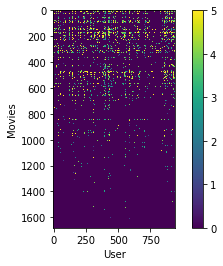

In [873]:
plt.imshow(Y)
plt.colorbar()
plt.xlabel('User')
plt.ylabel('Movies')
plt.show()

In [969]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features,lamdba):
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    #Only on R = 1 elements!  
    tmp = np.multiply(np.dot(X,Theta.transpose()) - Y, R)
    x_grad = np.dot(tmp, Theta) + lamdba*X
    theta_grad = np.dot(tmp.transpose(),X) + lamdba*Theta
    grad = np.concatenate((np.ravel(x_grad), np.ravel(theta_grad)))
    theta2 = lamdba*0.5*np.sum(np.square(Theta))
    x2 = lamdba*0.5*np.sum(np.square(X))
    J = 0.5*np.sum(np.square(tmp)) + x2 + theta2    
    return J, grad

In [912]:
def cofiCostFuncGrad(params, Y, R, num_users, num_movies, num_features,lamdba):
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    #Only on R = 1 elements!  
    tmp = np.multiply(np.dot(X,Theta.transpose()) - Y, R)
    x_grad = np.dot(tmp, Theta) + lamdba*X
    theta_grad = np.dot(tmp.transpose(),X) + lamdba*Theta
    grad = np.concatenate((np.ravel(x_grad), np.ravel(theta_grad)))
    theta2 = lamdba*0.5*np.sum(np.square(Theta))
    x2 = lamdba*0.5*np.sum(np.square(X))
    J = 0.5*np.sum(np.square(tmp)) + x2 + theta2    
    return grad

In [877]:
#Verify the implementation of cofiCostFunc is correct
input_params = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex8\machine-learning-ex8\ex8\ex8_movieParams.mat")
X = input_params['X']
theta = input_params['Theta']
R = input_data['R']
Y = input_data['Y']
num_movies = 5
num_features=3
num_users=4
X = X[0:num_movies, 0:num_features]
theta = theta[0:num_users, 0:num_features]
Y = Y[0:num_movies, 0:num_users]
R = R[0:num_movies, 0:num_users]

params = np.concatenate((np.ravel(X), np.ravel(theta)))
cofiCostFunc(params, Y, R, 4, 5, 3, 1.5)

(31.344056244274217,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

In [878]:
def movie_list():
    with open(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex8\machine-learning-ex8\ex8\movie_ids.txt", 'r') as f:
        l = []
        t = f.readlines()
        for i in range(len(t)):
            parts = t[i].split()
            l.append(' '.join(parts[1:]))
    return l

In [879]:
#Get the movie list and add ratings
input_params = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex8\machine-learning-ex8\ex8\ex8_movieParams.mat")
X = input_params['X']
l = movie_list()
my_ratings = np.zeros((X.shape[0],1))
my_ratings[0] = 4;
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63]= 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[97] = 2;
my_ratings[182] = 4;
my_ratings[225] = 5;
my_ratings[354]= 5;
for i in range(X.shape[0]):
    if my_ratings[i]!=0:
        print(l[i])
        print(my_ratings[i])

Toy Story (1995)
[4.]
Twelve Monkeys (1995)
[3.]
Usual Suspects, The (1995)
[5.]
Outbreak (1995)
[4.]
Shawshank Redemption, The (1994)
[5.]
While You Were Sleeping (1995)
[3.]
Forrest Gump (1994)
[5.]
Silence of the Lambs, The (1991)
[2.]
Alien (1979)
[4.]
Die Hard 2 (1990)
[5.]
Sphere (1998)
[5.]


In [890]:
def normalizeRatings(Y, R):
    Ymean=np.zeros(Y.shape[0])
    Ynorm = np.zeros((Y.shape[0], Y.shape[1]))
    for i in range(Y.shape[0]):
        idx = np.where(R[i,:] == 1)[1]
        Ymean[i] = Y[i,idx].mean()
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]
    return Ynorm, Ymean

In [980]:
#Add my ratings into the Y & R for training
my_ratings = np.matrix(my_ratings).reshape(1682,1)
input_data = scipy.io.loadmat(r"C:\Users\Yow-Gwo Wang\Desktop\ML\machine-learning-ex8\machine-learning-ex8\ex8\ex8_movies.mat")
Y = input_data['Y']
R = input_data['R']
Y = np.append(Y, my_ratings, axis=1)
R = np.append(R, (my_ratings != 0), axis=1)
Ynorm, Ymean = normalizeRatings(Y, R)
X = np.random.rand(1682, 10)
Theta = np.random.rand(944, 10)
params = np.concatenate((np.ravel(X), np.ravel(Theta)))
#These 2 methods gives you similar results using Y
#But if you use Ynorm, There is no way I can get similar results as Hw suggested
result = opt.minimize(fun=cofiCostFunc, x0=params, args=(Y, R, Y.shape[1], Y.shape[0], X.shape[1],10), 
                      method='TNC', jac=True, options={'maxiter': 10000})
#result2 = opt.fmin_cg(cofiCostFunc, x0=params, fprime=cofiCostFuncGrad, args=(Y,R,Y.shape[1],Y.shape[0],X.shape[1],10),maxiter=50,disp=True,full_output=True)
params_fit = np.matrix(result.x)
#params_fit2 = np.matrix(result2[0])


In [981]:
#I think for this exercise, no need to use feature normalizatoin
#Since the input data set and user data set is in same scale
#Lots of people using Y for optimziaiton and then + Ymean
#to make the number closer to the HW slides...
#It's confusing.....
X = np.matrix(np.reshape(params_fit[:,0:1682 * 10], (1682, 10)))
Theta = np.matrix(np.reshape(params_fit[:, 1682 * 10:], (944, 10)))    
pred = X*Theta.transpose()

my_preds = pred[:, -1]
#+ Ymean.reshape(1682,1)
my_preds.shape
idx = np.argsort(my_preds, axis=0)[::-1]
print('Recommend for you:')
for i in range(10):
    print(l[int(idx[i])])
    print(float(my_preds[idx[i]]))
print('\nYour input ratings:')
for i in range(X.shape[0]):
    if my_ratings[i]!=0:
        print(l[i])
        print(float(my_ratings[i]))

Recommend for you:
Titanic (1997)
4.291395948709657
Star Wars (1977)
4.119951886909213
Raiders of the Lost Ark (1981)
3.979220934426015
Good Will Hunting (1997)
3.9099954225760625
Shawshank Redemption, The (1994)
3.885805954809931
Return of the Jedi (1983)
3.872955265893991
Braveheart (1995)
3.871294265218666
Empire Strikes Back, The (1980)
3.8630052149106695
Terminator 2: Judgment Day (1991)
3.7579327784350323
As Good As It Gets (1997)
3.7576852997719286

Your input ratings:
Toy Story (1995)
4.0
Twelve Monkeys (1995)
3.0
Usual Suspects, The (1995)
5.0
Outbreak (1995)
4.0
Shawshank Redemption, The (1994)
5.0
While You Were Sleeping (1995)
3.0
Forrest Gump (1994)
5.0
Silence of the Lambs, The (1991)
2.0
Alien (1979)
4.0
Die Hard 2 (1990)
5.0
Sphere (1998)
5.0
